Using device: cuda
Sample Rate of the model: 16000


Saving hello-there.mp3 to hello-there (3).mp3
Uploaded file: hello-there (3).mp3

--- Recognition Result ---
Predicted Transcript: HALLO THER

--- Original Audio ---


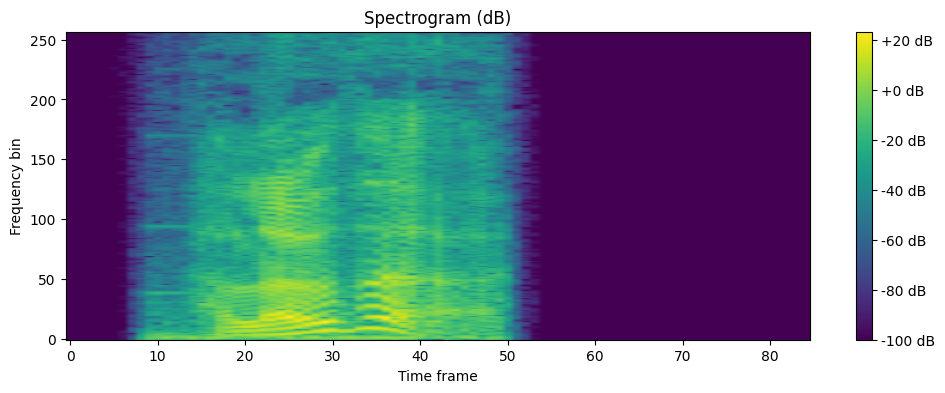

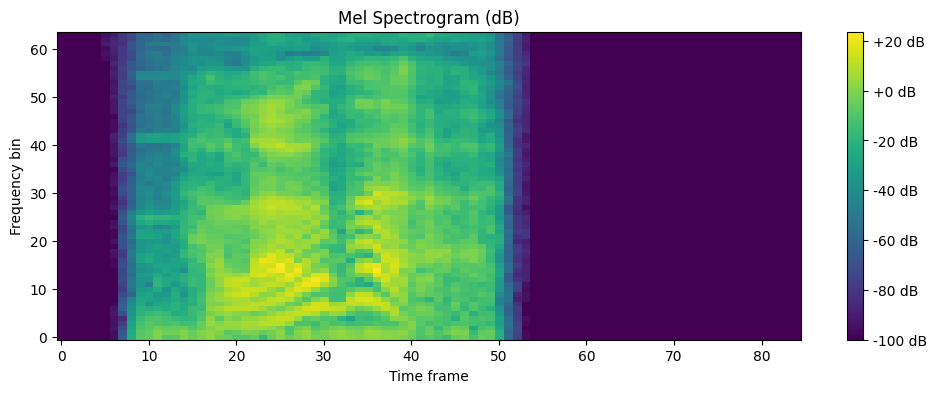

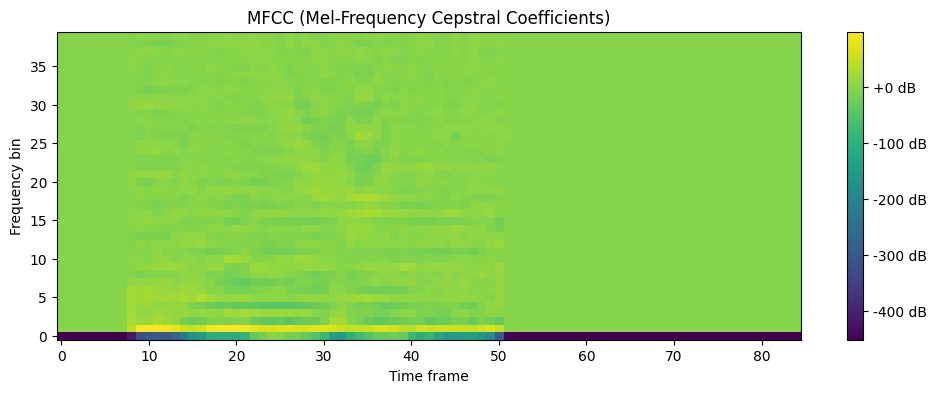

In [3]:
import torch
import torchaudio
import torchaudio.transforms as T
import torchaudio.pipelines as pipelines
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
from google.colab import files


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Wav2Vec2 ASR (Automatic Speech Recognition) 파이프라인 불러오기
bundle = pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)

print(f"Sample Rate of the model: {bundle.sample_rate}")

# 1. 로컬 파일을 Colab에 업로드
uploaded = files.upload()
if not uploaded:
    print("파일이 업로드되지 않았습니다.")
else:
    filepath = next(iter(uploaded))
    print(f"Uploaded file: {filepath}")

    # 2. 오디오 파일 불러오기 및 리샘플링
    try:
        waveform, sample_rate = torchaudio.load(filepath)
        if sample_rate != bundle.sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=bundle.sample_rate)
            waveform = resampler(waveform)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        waveform = waveform.to(device)

        # 3. 음성 인식 실행
        with torch.no_grad():
            emission, _ = model(waveform)

        # 4. 결과 디코딩
        class_labels = list(bundle.get_labels())
        indices = torch.argmax(emission[0], dim=-1)
        indices = torch.unique_consecutive(indices)
        blank_index = 0
        indices = [i for i in indices if i != blank_index]

        transcript = "".join([class_labels[i] for i in indices])
        transcript = transcript.replace("|", " ").strip()

        print("\n--- Recognition Result ---")
        print(f"Predicted Transcript: {transcript}")

        print("\n--- Original Audio ---")
        ipd.display(ipd.Audio(waveform.cpu().numpy(), rate=bundle.sample_rate))

    except Exception as e:
        print(f"오디오 파일을 처리하는 중 오류가 발생했습니다: {e}")

def plot_feature(feature, title):
    plt.figure(figsize=(12, 4))
    plt.imshow(feature.cpu().numpy(), aspect='auto', origin='lower')
    plt.title(title)
    plt.ylabel("Frequency bin")
    plt.xlabel("Time frame")
    plt.colorbar(format='%+2.0f dB')
    plt.show()


if 'waveform' in locals():
    # 1. 스펙트로그램 (Spectrogram)
    spectrogram_transform = T.Spectrogram(n_fft=512).to(device)
    spectrogram = spectrogram_transform(waveform)
    db_spectrogram = torchaudio.functional.amplitude_to_DB(spectrogram, multiplier=10., amin=1e-10, db_multiplier=0)
    plot_feature(db_spectrogram[0], "Spectrogram (dB)")

    # 2. 멜 스펙트로그램 (Mel Spectrogram)
    melspectrogram_transform = T.MelSpectrogram(
        sample_rate=bundle.sample_rate,
        n_fft=512,
        n_mels=64
    ).to(device)
    melspectrogram = melspectrogram_transform(waveform)
    db_melspectrogram = torchaudio.functional.amplitude_to_DB(melspectrogram, multiplier=10., amin=1e-10, db_multiplier=0)
    plot_feature(db_melspectrogram[0], "Mel Spectrogram (dB)")

    # 3. 멜-주파수 캡스트럼 계수 (MFCC)
    mfcc_transform = T.MFCC(
        sample_rate=bundle.sample_rate,
        n_mfcc=40, # 추출할 MFCC 계수의 수
        melkwargs={'n_fft': 512, 'n_mels': 64}
    ).to(device)
    mfcc = mfcc_transform(waveform)
    plot_feature(mfcc[0], "MFCC (Mel-Frequency Cepstral Coefficients)")
else:
    print("음성 파일이 먼저 업로드되어야 특징 추출을 실행할 수 있습니다.")
